In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from einops import rearrange
import requests
import io
import json
from tqdm import tqdm
import mediapy as media
import jax
import numpy as np

In [2]:
%load_ext line_profiler

In [3]:
#!ls -lt baselines

In [4]:
run_dir = Path('baselines/mini_agent_stats') # Path('baselines/session_ebdfe818')
# original session_e41c9eff, main session_4da05e87, extra session_e1b6d2dc

In [5]:
dfs = []
for run in tqdm(run_dir.glob('*.gz')):
    tdf = pd.read_csv(run, compression='gzip')
    dfs.append(tdf[tdf['map'] != 'map'])

5it [01:20, 16.11s/it]


In [6]:
def make_all_coords_arrays(filtered_dfs):
    return np.stack([tdf[['x', 'y', 'map']].to_numpy().astype(np.uint8) for tdf in filtered_dfs]).transpose(1,0,2)

In [7]:
def load_tex(name):
    resp = requests.get(sprites[name])
    return np.array(Image.open(io.BytesIO(resp.content)))

In [8]:
def get_sprite_by_coords(img, x, y):
    sy = 34+17*y
    sx = 9 +17*x
    alpha_v = np.array([255, 127,  39, 255], dtype=np.uint8)
    sprite = img[sy:sy+16, sx:sx+16]
    return np.where((sprite == alpha_v).all(axis=2).reshape(16,16,1), np.array([[[0,0,0,0]]]), sprite).astype(np.uint8)


In [102]:
def game_coord_to_pixel_coord(
    x, y, map_idx, overlay_map):
    
    global_offset = np.array([1056-16*12, 331]) #np.array([790, -29])
    map_offsets = {
        # https://bulbapedia.bulbagarden.net/wiki/List_of_locations_by_index_number_(Generation_I)
        0: np.array([0,0]), # pallet town
        1: np.array([-10, 72]), # viridian
        2: np.array([-10, 180]), # pewter
        12: np.array([0, 36]), # route 1
        13: np.array([0, 144]), # route 2
        14: np.array([30, 172]), # Route 3
        15: np.array([80, 190]), #Route 4
        33: np.array([-50, 64]), # route 22
        37: np.array([-9, 2]), # red house first
        38: np.array([-9, 25-32]), # red house second
        39: np.array([9+12, 2]), # blues house
        40: np.array([25-4, -6]), # oaks lab
        41: np.array([30, 47]), # Pokémon Center (Viridian City)
        42: np.array([30, 55]), # Poké Mart (Viridian City)
        43: np.array([30, 72]), # School (Viridian City)
        44: np.array([30, 64]), # House 1 (Viridian City)
        47: np.array([21,136]), # Gate (Viridian City/Pewter City) (Route 2)
        49: np.array([21,108]), # Gate (Route 2)
        50: np.array([21,108]), # Gate (Route 2/Viridian Forest) (Route 2)
        51: np.array([-35, 137]), # viridian forest
        52: np.array([-10, 189]), # Pewter Museum (floor 1)
        53: np.array([-10, 198]), # Pewter Museum (floor 2)
        54: np.array([-21, 169]), #Pokémon Gym (Pewter City)
        55: np.array([-19, 177]), #House with disobedient Nidoran♂ (Pewter City)
        56: np.array([-30, 163]), #Poké Mart (Pewter City)
        57: np.array([-19, 177]), #House with two Trainers (Pewter City)
        58: np.array([-25, 154]), # Pokémon Center (Pewter City)
        59: np.array([83, 227]), # Mt. Moon (Route 3 entrance)
        60: np.array([123, 227]), # Mt. Moon
        61: np.array([152, 227]), # Mt. Moon
        68: np.array([65, 190]), # Pokémon Center (Route 4)
        193: None # Badges check gate (Route 22)
    }
    if map_idx in map_offsets.keys():
        offset = map_offsets[map_idx]
    else:
        offset = np.array([0,0])
        x, y = 0, 0
    coord = global_offset + 16*(offset + np.array([x,y]))
    coord[1] = overlay_map.shape[0] - coord[1]
    return coord

In [94]:
def add_sprite(overlay_map, sprite, coord):
    raw_base = (overlay_map[coord[1]:coord[1]+16, coord[0]:coord[0]+16, :])
    intermediate = raw_base
    mask = sprite[:, :, 3] != 0
    if (mask.shape != intermediate[:,:,0].shape):
        #print(f'requested coords: {coord[1]}-{coord[1]+16}, {coord[0]}-{coord[0]+16}')
        #print(f'overlay_map.shape {overlay_map.shape}')
        #print(f'mask.shape {mask.shape} intermediate[:,:,0].shape {intermediate[:,:,0].shape}')
        #print(f'x {x} y {y} map {map_idx}')
        return {'coords': coord}
    else:
        intermediate[mask] = sprite[mask]
    overlay_map[coord[1]:coord[1]+16, coord[0]:coord[0]+16, :] = intermediate

In [95]:
def blend_overlay(background, over):
    al = over[...,3].reshape(over.shape[0], over.shape[1], 1)
    ba = (255-al)/255
    oa = al/255
    return (background[..., :3]*ba + over[..., :3]*oa).astype(np.uint8)

In [96]:
def render_coords(coords, over):
    for runs in coords:
        for x,y,mp in runs:
            add_sprite(over, walks[0], int(x), -int(y), mp, add=False)

In [97]:
def split(img):
    return rearrange(img, '(s y) x c -> y (s x) c', s=2)

In [98]:
def split(img):
    return img

In [99]:
def render_video(fname, all_coords, bg, inter_steps=4):
    debug = False
    errors = []
    sprites_rendered = 0
    with media.VideoWriter(f'{fname}.mov', split(bg).shape[:2], codec='prores_ks', encoded_format='yuva444p', input_format='rgba', fps=60) as wr:
        step_count = len(all_coords)
        state = [{'dir': 0, 'map': 40} for _ in all_coords[0]]
        pbar = tqdm(range(1, step_count))
        for idx in pbar:
            step = all_coords[idx]
            prev_step = all_coords[idx-1]
            if debug:
                print('-- step --')
            for fract in np.arange(0,1,1/inter_steps):
                over = np.zeros_like(bg, dtype=np.uint8)
                for run in range(len(step)):
                    cur = step[run]
                    prev = prev_step[run]
                    # cast to regular int from uint8
                    cx, cy, px, py = map(int, [cur[0], cur[1], prev[0], prev[1]])
                    dx = cx - px
                    dy = cy - py
                    total_delta = abs(dx) + abs(dy)
                    if total_delta > 1:
                        state[run]['map'] = cur[2]
                    dx = min(max(dx, -1), 1)
                    dy = -1*min(max(dy, -1), 1)
                    if debug:
                        print(f'x: {cx} y: {cy} dx: {dx} dy: {dy}')
                    # only change direction if not moving between maps
                    if cur[2] == prev[2]:
                        if dx > 0:
                            state[run]['dir'] = 3
                        elif dx < 0:
                            state[run]['dir'] = 2
                        elif dy > 0:
                            state[run]['dir'] = 1
                        elif dy < 0:
                            state[run]['dir'] = 0

                    p_coord = game_coord_to_pixel_coord(
                        cx, -cy, state[run]['map'], over
                    )
                    prev_p_coord = game_coord_to_pixel_coord(
                        px, -py, prev[2], over
                    )
                    diff = p_coord - prev_p_coord
                    interp_coord = prev_p_coord + (fract*(diff.astype(np.float))).astype(np.int)
                    if np.linalg.norm(diff) > 16:
                        continue
                    error = add_sprite(
                        over, walks[state[run]['dir']],
                        interp_coord
                    )
                    if error is not None:
                        errors.append(error)
                    else:
                        sprites_rendered += 1
                wr.add_image(split(over[:,:,:]))
                perc = len(errors) / (sprites_rendered + len(errors))
                pbar.set_description(f"draws: {sprites_rendered} errors: {len(errors)}, {perc:.2%}")
    return errors

In [83]:
n = 4
sp_n = 16//n
np.arange(sp_n, 16+sp_n, sp_n, dtype=np.int)

array([ 4,  8, 12, 16])

In [84]:
#sprites = {
#    'characters': 'https://www.spriters-resource.com/resources/sheets/8/8728.png',
#    0: 'https://www.spriters-resource.com/resources/sheets/52/55181.png'
#}
main_map = np.array(Image.open('poke_map/pokemap_full_calibrated_CROPPED_1.png'))
chars_img = np.array(Image.open('poke_map/characters.png'))
alpha_val = get_sprite_by_coords(chars_img, 1, 0)[0,0]
walks = [get_sprite_by_coords(chars_img, x, 0) for x in [1, 4, 6, 8]]

In [85]:
base_coords = make_all_coords_arrays(dfs)

In [86]:
base_coords.shape

(9994850, 5, 3)

In [87]:
# fold over some runs on top of each other
rearrange(base_coords, '(v s) r c -> s (r v) c', v=610).shape

(16385, 3050, 3)

In [88]:
start_bg = main_map.copy()#*0+255

In [101]:
#%%prun
render_errs = render_video(
    'test_run',
    rearrange(base_coords, '(v s) r c -> s (r v) c', v=610)[0:5000],
    start_bg, inter_steps=8
)


draws: 120233000 errors: 120, 0.00%: 100%|██████████| 4999/4999 [7:35:50<00:00,  5.47s/it]


In [422]:
start_bg.shape

(4000, 4000, 4)

In [93]:
overlay = np.zeros_like(start_bg, dtype=np.uint8)
render_coords(rearrange(base_coords, '(v s) r c -> s (r v) c', v=610)[0::1200], overlay)
img_full = blend_overlay(start_bg, overlay)#[800:3970, 500:1600]

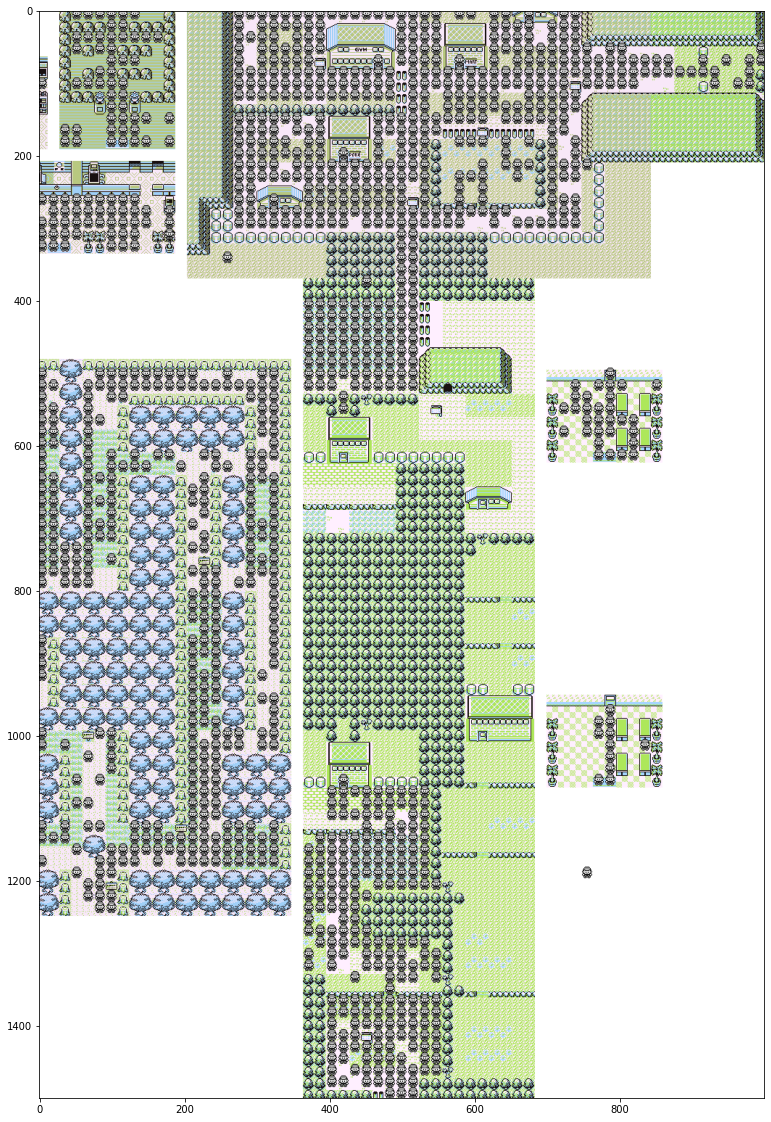

In [70]:
plt.figure(figsize = (20,20))
plt.imshow(img_full[1000:2500,500:1500])

In [40]:
from PIL import Image
im = Image.fromarray(overlay)
im.save("test_render_trans.png")

In [262]:
# find time spent holding each pokemon
all_poke_ids = {}
for df in dfs:
    for step in tqdm(df['ptypes']):
        pokes = json.loads(step)
        for p in pokes:
            if p in all_poke_ids.keys():
                all_poke_ids[p] += 1
            else:
                all_poke_ids[p] = 1

100%|██████████| 9994850/9994850 [00:42<00:00, 237251.67it/s]


In [263]:
# https://tcrf.net/Pok%C3%A9mon_Red_and_Blue/Internal_Index_Number
all_poke_ids

{177: 37600592,
 255: 49327310,
 0: 95664853,
 165: 39991280,
 36: 54695513,
 179: 12356844,
 150: 676610,
 112: 561622,
 113: 209597,
 133: 8317692,
 169: 121749,
 107: 204188,
 109: 53943,
 100: 2672,
 84: 40934,
 124: 11724,
 4: 8377}

In [343]:
cop = walks[1].copy()
mask = walks[2][:, :, 3] != 0
cop[mask] = walks[2][mask]

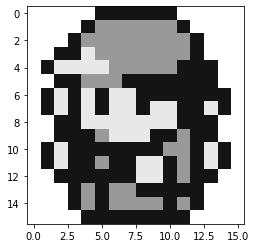

In [344]:
plt.imshow(cop)